In [7]:
## Change file path names in getAmpsDesired and getRaftData, as filename 

In [5]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
from fastparquet import write
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas
import os 
import os.path

## Demonstrate Data Structure

Dataframes save all data from the calibrated ADC edges, ADU bins not included are not calibrated by this method. Higher ADU easily, as selected 90k ADU as an ending point, but lower ADU are more delicate/ involved due to method of calibration and sensitivity to structure in calibrating dataset. 

In [20]:
def getDataFrameSensor(amplifierdesired): # yields the left edge of the specified calibrated ADC bin 
    ## read the file 
    sensorname = amplifierdesired[:7]
    amp = amplifierdesired[8:]
    ## Change file pathname
    filename = f'/sdf/data/rubin/user/rejnicho/ADCEdgesSensor/{sensorname}ADCEdges.parquet'
    df = pd.read_parquet(filename, engine='pyarrow')
    print(df)


In [19]:
getDataFrameSensor("R31_S00_C10")

                    edges
amp bin_idx              
C00 26789    26789.000000
    26790    26789.960850
    26791    26791.123028
    26792    26792.106854
    26793    26793.056004
...                   ...
C17 89996    89995.993530
    89997    89997.087688
    89998    89998.075500
    89999    89999.071403
    90000    90000.000196

[1013392 rows x 1 columns]


## Sample Conversion Function from rawADU to calibrated DNL ADC Edge

yields the left edge of the ADC bin

In [16]:
def getADULeftEdge(amplifierdesired, rawADU): # yields the left edge of the specified calibrated ADC bin 
    ## read the file 
    sensorname = amplifierdesired[:7]
    amp = amplifierdesired[8:]
    ## Change file pathname
    filename = f'/sdf/data/rubin/user/rejnicho/ADCEdgesSensor/{sensorname}ADCEdges.parquet'
    df = pd.read_parquet(filename, engine='pyarrow')
    calibratedADUleft = float(df.loc[(amp, rawADU), "edges"])
    return calibratedADUleft

def getADUMidpointEdge(amplifierdesired, rawADU):# yields the midpoint of the specified calibrated ADC bin 
    ## read the file 
    sensorname = amplifierdesired[:7]
    amp = amplifierdesired[8:]
    ## Change file pathname
    filename = f'/sdf/data/rubin/user/rejnicho/ADCEdgesSensor/{sensorname}ADCEdges.parquet'
    df = pd.read_parquet(filename, engine='pyarrow')
    calibratedADUleft = float(df.loc[(amp, rawADU), "edges"])
    calibratedADUright = float(df.loc[(amp, rawADU+1), "edges"])
    calibratedADUHalfBinwidth = (calibratedADUright - calibratedADUleft)/ 2
    calibratedADUmidpoint = calibratedADUleft + calibratedADUHalfBinwidth
    
    return calibratedADUmidpoint 

In [15]:
getADULeftEdge("R31_S00_C10", 30000)
getADUMidpointEdge("R31_S00_C10", 30000)

30000.557177405288

## Examine the same ADU for all amps on a raft

In [26]:
def combineAmpsData(datadict): 
    # the top row is 3*8 = 24 units across S20, S21, S22 
    combineddata = [] # the proper order of the values 
    data07 = [] # amplifiers 00-07 
    data1017 = [] # amplifiers 10-17 
    
    for sensor in datadict: 
        ampdata = datadict[sensor] 
        data07.extend(ampdata[:8]) #first 8 amps are the 00-07 
        data1017.extend(ampdata[8:]) #second 8 amps are 10-17 

    ## now we want to have the order be correct for the full, so 3*8* = 24 elements per row (that is 16 amps per sensor, and 9 sensors per raft), total 144 elements
    combineddata.extend(data07[:24])
    combineddata.extend(data1017[:24])    
    combineddata.extend(data07[24:48])
    combineddata.extend(data1017[24:48])
    combineddata.extend(data07[48:])
    combineddata.extend(data1017[48:])
    ## reshape the data so that it is an array that is 8*3 = 24 x 6 
    reshapeddata = np.array(combineddata).reshape(6, 24)

    return reshapeddata

def getRaftData(raft, rawADU): 
  
        ## we want the sensors to be in the order they are typically viewed in 
    sensordorder = ["S20", "S21", "S22", 
                        "S10", "S11", "S12", 
                        "S00", "S01", "S02"]
    indexdict = [[0,0], [0,1], [0,2], 
                     [1,0], [1,1], [1,2], 
                     [2,0], [2,1], [2,2]]

        ## amp order we want to realize that the order of the amp matters 
    amporder = ["C00", "C01", "C02", "C03", "C04", "C05", "C06", "C07",
                   "C10", "C11", "C12", "C13", "C14", "C15", "C16", "C17"]

        # what you truly want is 0-7 for S20, 0-7 S21, 0-7 S22 then 10-17 S20, 10-17 S21, ... 
        # so make 2 data subparts, then combine them together 
        
    datadict = {} # dictionary of the values to be plotted, in order of of amplifiers 
        
    for sensor in sensordorder: # iterates in the order in which this will be plotted 
        data = [] # values of the desired value 0-7             
            
        for ampname in amporder: # iterates in the way to be plotted 
            fullampname = raft+"_"+sensor+"_"+ampname                 
            desiredADU = getADULeftEdge(fullampname, rawADU)
                
            data.append(float(desiredADU))
            
        datadict[sensor] = data 
        
        # order the datadict such that you get an array in the desired order 
    dataset = combineAmpsData(datadict)
        
    return dataset 

def plotSingleRaft(raft, rawADU, low, high): 
    plt.figure(figsize=(7, 5))
    
    data = getRaftData(raft, rawADU) # get the requested information in the proper order 
    im = plt.imshow(data, cmap='viridis', interpolation='none', aspect='auto', vmin=low, vmax=high)
    plt.title(f"{raft}, each ADC at {rawADU}")
    plt.colorbar()


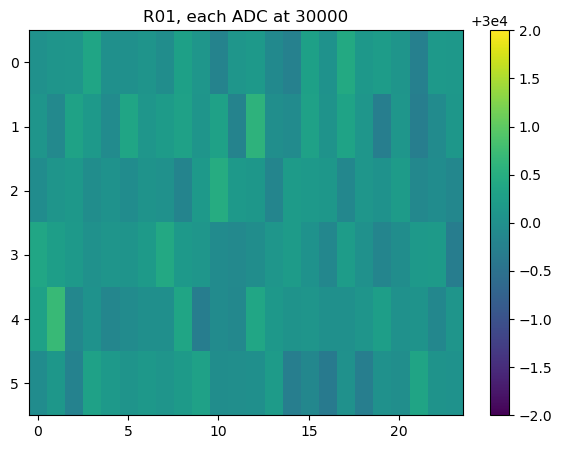

In [27]:
# select raft, adu to plot, and lower/upper bounds of the plot 
plotSingleRaft("R01", 30000, 29998, 30002)